In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyomo.environ as pyo
import matplotlib.dates as mdates
from load_data_PLD import get_load_data, get_gen_data, get_spot_prices_data
from scipy.interpolate import make_interp_spline
import datetime as dt

In [67]:
# Algumas configurações dos valores de carga, geração e armazenamento a serem carregados

load_max = 25e6#original: 5e6#maiores testes foram com 25
#load_max = 100e6#original: 5e6#maiores testes foram com 25
gen_max = 150e6#original: 75e6#maiores testes foram com 150
node_index = 45#original:45
N = 96

 
$A_{max} = 25 \times 10^6 \ \text{kWh}$


$G_{max_solar} = 150 \times 10^6 \ \text{kWh}$

$G_{max_wind} = 150 \times 10^6 \ \text{kWh}$

 
$i = 45$

 
$N = 96$


In [68]:
# Sistema de armazenamento de hidrogênio

h2_storage_size_kg = 22.8e3 # unidade em Kg#maiores testes foram com 7600--->30400-->22.7e3(22,8 toneladas por dia)
h2_storage_rate = 0.3
h2_storage_min_soc = 0.00 * h2_storage_size_kg
h2_storage_max_soc = 1.00 * h2_storage_size_kg

elec_storage_size_wh = 1e6
elec_storage_rate = 0.1
elec_storage_min_soc = 0.05 * elec_storage_size_wh
elec_storage_max_soc = 0.95 * elec_storage_size_wh

### Parâmetros do Armazenamento de Hidrogênio:

- Capacidade total de armazenamento:  
  $H_{max} = 22.8 \times 10^3 \ \text{kg}$

- Taxa de armazenamento (carga/descarga):  
  $\eta_H = 0.3$

- Mínimo de carga (SOC):  
  $SOC_{H}^{min} = 0.00 \cdot H_{max} = 0 \ \text{kg}$

- Máximo de carga (SOC):  
  $SOC_{H}^{max} = 1.00 \cdot H_{max} = 22.8 \times 10^3 \ \text{kg}$

---

### Parâmetros do Armazenamento de Energia Elétrica:

- Capacidade total de armazenamento:  
  $E_{max} = 1.0 \times 10^6 \ \text{Wh}$

- Taxa de armazenamento (carga/descarga):  
  $\eta_E = 0.1$

- Mínimo de carga (SOC):  
  $SOC_{E}^{min} = 0.05 \cdot E_{max} = 0.05 \times 10^6 \ \text{Wh}$

- Máximo de carga (SOC):  
  $SOC_{E}^{max} = 0.95 \cdot E_{max} = 0.95 \times 10^6 \ \text{Wh}$


In [69]:
# Sistema de armazenamento de hidrogênio

h2_storage_size_kg = 22.8e3 # unidade em Kg#maiores testes foram com 7600--->30400-->22.7e3(22,8 toneladas por dia)
h2_storage_rate = 0.3
h2_storage_min_soc = 0.00 * h2_storage_size_kg
h2_storage_max_soc = 1.00 * h2_storage_size_kg

elec_storage_size_wh = 1e6
elec_storage_rate = 0.1
elec_storage_min_soc = 0.05 * elec_storage_size_wh
elec_storage_max_soc = 0.95 * elec_storage_size_wh


## Sistema de Armazenamento de Hidrogênio

- Capacidade total de armazenamento:  
  $H_{\text{max}} = 22{,}800 \ \text{kg}$

- Carga/descarga:  
  $\eta_H = 0{,}3$

- Mínimo de carga (SOC):  
  $SOC_H^{\text{min}} = 0{,}00 \cdot H_{\text{max}} = 0 \ \text{kg}$

- Máximo de carga (SOC):  
  $SOC_H^{\text{max}} = 1{,}00 \cdot H_{\text{max}} = 22{,}800 \ \text{kg}$

**Restrições operacionais:**

$$
SOC_H(t) \in \left[ SOC_H^{\text{min}},\ SOC_H^{\text{max}} \right]
$$

$$
|\Delta SOC_H(t)| \leq \eta_H \cdot H_{\text{max}}
$$



In [70]:
time = np.arange(N)

In [71]:
# Taxa de conversão de H2 para Eletricidade
tx_elec_to_h2 = 55.62e3 # (Wh/kg de H2) (dados do artigo do CBA)
tx_h2_to_elec = 86.25e-6 # (kg de H2/Wh) Considerando eficiencia da SGT-400=34,8% em ciclo aberto: Original 86.25e-6

efi_elec_to_h2 = 0.755 #FONTE: Siemens Elyzer P-300: 0.755
efi_h2_to_elec = 0.348 #------Dados turbina Siemens SGT-400: 34,8%
efi_h2_storage_in = 0.9
efi_h2_storage_out = 0.9
efi_elec_in = 0.9
efi_elec_out = 0.9

## Taxas de Conversão entre Eletricidade e Hidrogênio

- Conversão de eletricidade para hidrogênio (eletrólise):  
  $\text{tx}_{E \rightarrow H_2} = 55{,}620 \ \text{Wh/kg}_{H_2}$

- Conversão de hidrogênio para eletricidade (combustão/turbina):  
  $\text{tx}_{H_2 \rightarrow E} = 86{,}25 \times 10^{-6} \ \text{kg}_{H_2}/\text{Wh}$

---

## Eficiências de Conversão

- Eficiência da eletrólise:  
  $\eta_{E \rightarrow H_2} = 0{,}755$

- Eficiência da turbina (ciclo aberto):  
  $\eta_{H_2 \rightarrow E} = 0{,}348$

---

## Eficiências de Armazenamento

- Entrada no tanque de H₂:  
  $\eta_{H_2,\text{in}} = 0{,}9$

- Saída do tanque de H₂:  
  $\eta_{H_2,\text{out}} = 0{,}9$

- Entrada no armazenamento elétrico (bateria):  
  $\eta_{E,\text{in}} = 0{,}9$

- Saída do armazenamento elétrico (bateria):  
  $\eta_{E,\text{out}} = 0{,}9$


In [72]:
max_elec_to_h2_power = 52.5e6#3*17,5 eletrolizadores Elyzer P-300 para atender a vazão necessária da turbina SGT-400(11MW)

# Capacidade máxima de potência elétrica da usina térmica
max_gas_power = 11e6#SIEMENS SGT-A400 11MW
max_h2_to_elec_power = max_gas_power * 0.25 * tx_h2_to_elec # 0.25 significa tempo 1/4 de hora
min_uptime = 8 * 4

## Parâmetros de Potência

- Potência máxima de eletricidade para eletrólise (3 eletrolisadores Elyzer P-300):  
  $P_{E \rightarrow H_2}^{\text{max}} = 52{,}500{,}000 \ \text{W}$

- Potência máxima da turbina a gás (SGT-A400):  
  $P_{H_2 \rightarrow E}^{\text{nom}} = 11{,}000{,}000 \ \text{W}$

- Capacidade máxima de geração elétrica por 15 minutos:  
  $P_{H_2 \rightarrow E}^{\text{max}} = P_{H_2 \rightarrow E}^{\text{nom}} \cdot \dfrac{1}{4} \cdot \text{tx}_{H_2 \rightarrow E}$  
  $= 11{,}000{,}000 \cdot 0{,}25 \cdot 86{,}25 \times 10^{-6} \ \text{kg}_{H_2}$

---

## Tempo Mínimo de Operação da Turbina

- Tempo mínimo de operação contínua:  
  $T_{\text{on}}^{\text{min}} = 8 \cdot 4 = 32 \ \text{intervalos}$  
  (considerando 4 intervalos de 15 minutos por hora, ou seja, 8 horas)


In [73]:
load = get_load_data(node_index)[:96] * load_max
#load_max = 1.2  # ou outro valor que quiser
sload = np.sqrt(load.pload**2 + load.qload**2)
pv_gen = get_gen_data(node_index)[:96] * gen_max
spot_prices = get_spot_prices_data(30)[:96]

In [74]:
h2_price_start = 22.75  # Preço inicial do hidrogênio: 22.75 
h2_price_end = 49.94  # Limite superior do preço do hidrogênio:49,94
num_points = 96      # 96 intervalos de 15 minutos para 24 horas
smooth_factor = 1.5  # Fator de suavização para controlar a variação entre pontos

# Inicializando a lista com o preço inicial
h2_price = [np.random.uniform(h2_price_start, h2_price_end)]

# Gerar uma série de preços suavizados
for _ in range(1, num_points):
    # O próximo preço é baseado no preço anterior com uma pequena variação
    next_price = h2_price[-1] + np.random.uniform(-smooth_factor, smooth_factor)
    # Garantir que o preço esteja dentro dos limites definidos
    next_price = np.clip(next_price, h2_price_start, h2_price_end)
    
    h2_price.append(next_price)

# Converte para lista (se necessário)
h2_price = h2_price
plt.show()

## Dados de Entrada do Modelo

- Demanda de potência ativa:  
  $\text{load}(t) = \text{get\_load\_data}(i)[:96] \cdot \text{load}_{\text{max}}$

- Carga aparente (considerando potência ativa e reativa):  
  $S_{\text{load}}(t) = \sqrt{\text{P}_{\text{load}}(t)^2 + \text{Q}_{\text{load}}(t)^2}$

- Geração fotovoltaica estimada:  
  $P_{PV}(t) = \text{get\_gen\_data}(i)[:96] \cdot \text{gen}_{\text{max}}$

- Preço de eletricidade no mercado (30º dia):  
  $p_{\text{spot}}(t) = \text{get\_spot\_prices\_data}(30)[:96]$

---

**Observações:**
- $i = 45$: índice
- As séries de tempo têm 96 intervalos com resolução de 15 minutos.


GRÁFICO A SEGUIR ADICIONADO PARA VERIFICAR O PLD

<function matplotlib.pyplot.show(close=None, block=None)>

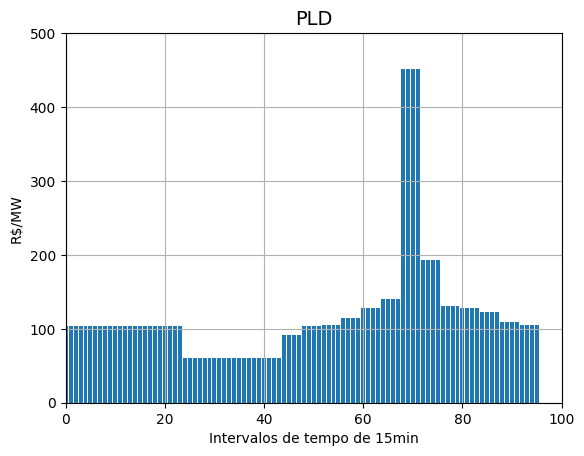

In [75]:
plt.bar(time, spot_prices.Price)
plt.xlim((0.0, 100.0))
plt.ylim((0.0, 500.0))
plt.grid(True)


#Identificando os elementos do gráfico
plt.title('PLD', fontsize=14)  # Título do gráfico
plt.xlabel('Intervalos de tempo de 15min', fontsize=10)  # Título do eixo X
plt.ylabel('R$/MW', fontsize=10)  # Título do eixo Y
plt.show

In [76]:
# %%
model = pyo.ConcreteModel(name='H2V')

model.time_set = pyo.Set(initialize=time)

In [77]:
# Lê os primeiros 96 valores da coluna "pwind" da planilha "dados"
wind_gen = pd.read_excel('wind_data.xlsx', sheet_name='Planilha1')

# Garante que estamos pegando apenas os primeiros 96 valores
wind_gen = wind_gen.head(96)

# Converte de MW para Watts, se necessário
wind_gen['pwind'] = wind_gen['pwind'] * 1e6


# Geração eólica sintética entre 21 MW e 94 MW, convertida para Watts
#wind_gen_random = np.random.uniform(21e6, 94e6, size=96)

# Cria um DataFrame compatível
#wind_gen = pd.DataFrame({'pwind': wind_gen_random})

In [78]:
model.param_wind_gen = pyo.Param(model.time_set, initialize=wind_gen.pwind.to_dict(), mutable=False)

#model.param_wind_gen = pyo.Param(model.time_set, initialize=wind_gen.pwind.to_dict(), mutable=False)

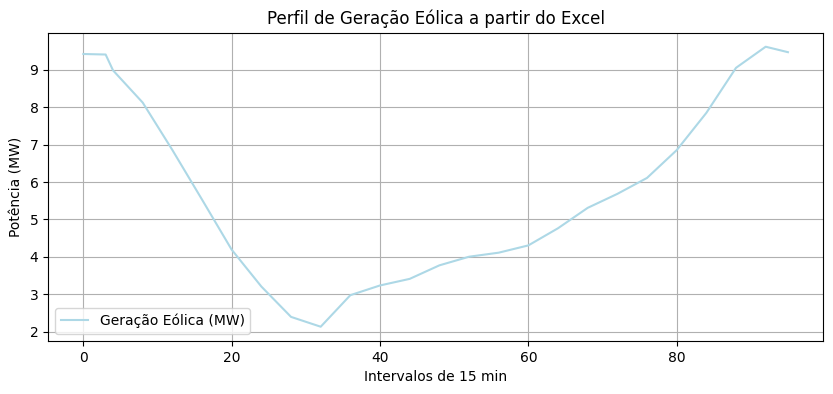

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(wind_gen.pwind / 1e6, label="Geração Eólica (MW)", color='lightblue')
plt.xlabel("Intervalos de 15 min")
plt.ylabel("Potência (MW)")
plt.grid(True)
plt.legend()
plt.title("Perfil de Geração Eólica a partir do Excel")
plt.show()

In [80]:
spot_price = get_spot_prices_data(30)[:96]  # <-- isso precisa ser executado antes

# Teste
print(spot_price.head())

# Depois disso, você pode criar o parâmetro
model.param_spot_prices = pyo.Param(model.time_set, initialize=spot_price.Price, mutable=False)


    Price
0  104.14
1  104.14
2  104.14
3  104.14
4  103.83


In [81]:
# Parâmetros de entrada
model.param_load = pyo.Param(model.time_set, initialize=load.pload.values, mutable=False)
model.param_pv_gen = pyo.Param(model.time_set, initialize=pv_gen.pgen.values, mutable=False)
#model.param_spot_prices = pyo.Param(model.time_set, initialize=spot_price.Price, mutable=False)

In [82]:
# Parâmetros do módulo de armazenamento de eletricidade
model.max_elec_charge = pyo.Param(initialize=elec_storage_rate * elec_storage_size_wh)
model.max_elec_discharge = pyo.Param(initialize=elec_storage_rate * elec_storage_size_wh)
model.elec_storage_size = pyo.Param(initialize=elec_storage_size_wh)
model.elec_min_soc = pyo.Param(initialize=elec_storage_min_soc)
model.elec_max_soc = pyo.Param(initialize=elec_storage_max_soc)

## Parâmetros do Modelo — Armazenamento Elétrico

- Taxa máxima de carga da bateria:  
  $\text{max\_elec\_charge} = \eta_E \cdot E_{\text{max}} = 0{,}1 \cdot 1{,}000{,}000 = 100{,}000 \ \text{Wh}$

- Taxa máxima de descarga da bateria:  
  $\text{max\_elec\_discharge} = \eta_E \cdot E_{\text{max}} = 100{,}000 \ \text{Wh}$

- Capacidade total de armazenamento elétrico:  
  $\text{elec\_storage\_size} = E_{\text{max}} = 1{,}000{,}000 \ \text{Wh}$

- Mínimo de carga (SOC mínimo):  
  $\text{elec\_min\_soc} = 0{,}05 \cdot E_{\text{max}} = 50{,}000 \ \text{Wh}$

- Máximo de carga (SOC máximo):  
  $\text{elec\_max\_soc} = 0{,}95 \cdot E_{\text{max}} = 950{,}000 \ \text{Wh}$


In [83]:
# Parâmetros do módulo de armazenamento de H2
model.max_h2_charge = pyo.Param(initialize=h2_storage_rate * h2_storage_size_kg)
model.max_h2_discharge = pyo.Param(initialize=h2_storage_rate * h2_storage_size_kg)
model.h2_storage_size = pyo.Param(initialize=h2_storage_size_kg)
model.h2_min_soc = pyo.Param(initialize=h2_storage_min_soc)
model.h2_max_soc = pyo.Param(initialize=h2_storage_max_soc)

## Parâmetros do Modelo — Armazenamento de Hidrogênio (H₂)

- Taxa máxima de entrada de hidrogênio (carga do tanque):  
  $\text{max\_h2\_charge} = \eta_{H_2} \cdot H_{\text{max}} = 0{,}3 \cdot 22{,}800 = 6{,}840 \ \text{kg}$

- Taxa máxima de saída de hidrogênio (descarga do tanque):  
  $\text{max\_h2\_discharge} = \eta_{H_2} \cdot H_{\text{max}} = 6{,}840 \ \text{kg}$

- Capacidade total de armazenamento de hidrogênio:  
  $\text{h2\_storage\_size} = H_{\text{max}} = 22{,}800 \ \text{kg}$

- Mínimo de carga do tanque (SOC mínimo):  
  $\text{h2\_min\_soc} = 0{,}00 \cdot H_{\text{max}} = 0 \ \text{kg}$

- Máximo de carga do tanque (SOC máximo):  
  $\text{h2\_max\_soc} = 1{,}00 \cdot H_{\text{max}} = 22{,}800 \ \text{kg}$


In [84]:
# Variáveis de compra/venda de energia
model.var_power_purchase = pyo.Var(model.time_set, domain=pyo.Reals)

## Variáveis de Compra/Venda de Energia

- Variável de compra de energia:  
  $\text{var\_power\_purchase}(t) \in \mathbb{R}$, onde $t \in \text{time\_set}$.


In [85]:
# Variáveis de armazenamento de eletricidade
model.var_elec_charging = pyo.Var(time, within=pyo.Binary)
model.var_elec_discharging = pyo.Var(time, within=pyo.Binary)
model.var_elec_charge = pyo.Var(time,
                                initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                domain=pyo.NonNegativeReals)
model.var_elec_discharge = pyo.Var(time,
                                   initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                   domain=pyo.NonNegativeReals)
model.var_elec_soc = pyo.Var(time,
                             domain=pyo.NonNegativeReals,
                             bounds=(model.elec_min_soc, model.elec_max_soc))

## Variáveis de Armazenamento de Eletricidade

- Variável binária para carga da bateria:  
  $\text{var\_elec\_charging}(t) \in \{0, 1\}$, onde $t \in \text{time}$.

  Esta variável indica se a bateria está sendo carregada no período $t$. 

- Variável binária para descarga da bateria:  
  $\text{var\_elec\_discharging}(t) \in \{0, 1\}$, onde $t \in \text{time}$.

- Variável contínua para carga da bateria:  
  $\text{var\_elec\_charge}(t) \geq 0$, onde $t \in \text{time}$.

  Quantidade de energia sendo carregada na bateria no período $t$.

- Variável contínua para descarga da bateria:  
  $\text{var\_elec\_discharge}(t) \geq 0$, onde $t \in \text{time}$.

  Quantidade de energia sendo descarregada da bateria no período $t$.

- Variável para o estado de carga (SOC) da bateria:  
  $\text{var\_elec\_soc}(t) \in [SOC_{\text{min}}, SOC_{\text{max}}]$.

  Estado de carga da bateria no período $t$, com limites definidos por $SOC_{\text{min}}$ e $SOC_{\text{max}}$.


In [86]:
# Variável de quantidade de eletricidade utilizada para produção de H2
model.var_elet_on_off = pyo.Var(time, within=pyo.Binary)

model.var_elec_to_h2_mass = pyo.Var(time,
                                    initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                    domain=pyo.NonNegativeReals)

## Variáveis de Produção de Hidrogênio a partir de Eletricidade

- Variável binária para ligar/desligar a eletrólise:  
  $\text{var\_elet\_on\_off}(t) \in \{0, 1\}$, onde $t \in \text{time}$.

  Esta variável indica se o processo de eletrólise (produção de hidrogênio) está ativo no período $t$. Se $\text{var\_elet\_on\_off}(t) = 1$, a eletrólise está ligada, caso contrário, está desligada.



In [87]:
# Variável de quantidade de massa de H2 produzida pelo eletrolisador 
model.var_h2_mass_from_elet = pyo.Var(time,
                                      initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                      domain=pyo.NonNegativeReals)

## Variável de Massa de H₂ Produzida pelo Eletrolisador

- Variável contínua para a massa de H₂ produzida:  
  $\text{var\_h2\_mass\_from\_elet}(t) \geq 0$, onde $t \in \text{time}$.


In [88]:
# Variável de quantidade de massa de H2 produzida pelo eletrolisador e destinada ao armazenamento
model.var_h2_mass_to_storage = pyo.Var(time,
                                       initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                       domain=pyo.NonNegativeReals)

## Variável de Massa de H₂ Destinada ao Armazenamento

- Variável contínua para a massa de H₂ destinada ao armazenamento:  
  $\text{var\_h2\_mass\_to\_storage}(t) \geq 0$, onde $t \in \text{time}$.



In [89]:
# Variável de quantidade de massa de H2 proveniente do armazenamento para ??
model.var_h2_mass_from_storage = pyo.Var(time,
                                         initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                         domain=pyo.NonNegativeReals)

## Variável de Massa de H₂ Proveniente do Armazenamento

- Variável contínua para a massa de H₂ proveniente do armazenamento:  
  $\text{var\_h2\_mass\_from\_storage}(t) \geq 0$, onde $t \in \text{time}$.



In [90]:
# Variável de quantidade de massa de H2 destinada à queima para produção de eletricidade
model.var_h2_mass_to_elec = pyo.Var(time,
                                       initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                       domain=pyo.NonNegativeReals)

## Variável de Massa de H₂ Destinada à Produção de Eletricidade

- Variável contínua para a massa de H₂ que será utilizada para gerar eletricidade:  
  $\text{var\_h2\_mass\_to\_elec}(t) \geq 0$, onde $t \in \text{time}$.


In [91]:
# Variável de quantidade de massa de H2 destinada para  comercialização direta
model.var_h2_mass_to_market = pyo.Var(time,
                                      initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                      domain=pyo.NonNegativeReals)

model.var_gas_power_on_off = pyo.Var(time, domain=pyo.Binary)

model.var_gas_start_up = pyo.Var(time, domain=pyo.Binary)

model.var_gas_shut_down = pyo.Var(time, domain=pyo.Binary)

model.var_elec_from_gas = pyo.Var(time,
                                  initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                  domain=pyo.NonNegativeReals)

## Variáveis de Comercialização de Hidrogênio e Operação da Usina a Gás

- Massa de H₂ destinada à comercialização direta:  
  $\text{var\_h2\_mass\_to\_market}(t) \geq 0$, onde $t \in \text{time}$.

---

- Variável binária de operação da turbina a gás:  
  $\text{var\_gas\_power\_on\_off}(t) \in \{0, 1\}$


- Variável binária de acionamento (ligamento) da turbina a gás:  
  $\text{var\_gas\_start\_up}(t) \in \{0, 1\}$


- Variável binária de desligamento da turbina a gás:  
  $\text{var\_gas\_shut\_down}(t) \in \{0, 1\}$


---

- Quantidade de eletricidade gerada a partir da queima de gás (hidrogênio):  
  $\text{var\_elec\_from\_gas}(t) \geq 0$

  Representa a energia elétrica (em Wh) gerada a partir da queima de H₂ na turbina durante o período $t$.


In [92]:
# TODO: model.var_gn_mass_to_plant

# Variáveis de armazenamento de H2
model.var_h2_charging = pyo.Var(time, within=pyo.Binary)
model.var_h2_discharging = pyo.Var(time, within=pyo.Binary)
model.var_h2_charge = pyo.Var(time,
                              initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                              domain=pyo.NonNegativeReals)
model.var_h2_discharge = pyo.Var(time,
                                 initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                 domain=pyo.NonNegativeReals)
model.var_h2_soc = pyo.Var(time,
                           domain=pyo.NonNegativeReals,
                           bounds=(model.h2_min_soc, model.h2_max_soc))

## Variáveis de Armazenamento de Hidrogênio (H₂)

- Variáveis binárias de operação do armazenamento:
  - $\text{var\_h2\_charging}(t) \in \{0, 1\}$ — indica se o sistema está carregando H₂ no tempo $t$.
  - $\text{var\_h2\_discharging}(t) \in \{0, 1\}$ — indica se o sistema está descarregando H₂ no tempo $t$.

- Variáveis contínuas:
  - $\text{var\_h2\_charge}(t) \geq 0$ — quantidade de massa de H₂ (em kg) que entra no armazenamento no tempo $t$.
  - $\text{var\_h2\_discharge}(t) \geq 0$ — quantidade de massa de H₂ (em kg) que sai do armazenamento no tempo $t$.
  - $\text{var\_h2\_soc}(t) \in [H2_{min}, H2_{max}]$ — estado de carga do armazenamento de H₂ no tempo $t$.

  Onde:
  - $H2_{min} = \text{model.h2\_min\_soc}$
  - $H2_{max} = \text{model.h2\_max\_soc}$


Restrição de nível máximo de armazenamento:

$X_{nivel} < A_{max}$

In [93]:
# Restrição de conversão Eletricidade -> H2

def max_eletroliser_power(model, t):
    return model.var_elec_to_h2_mass[t] == max_elec_to_h2_power * model.var_elet_on_off[t]

model.max_eletroliser_power_constraint = pyo.Constraint(time, rule=max_eletroliser_power)

def elec_to_h2_constraint(model, t):
    return (model.var_h2_mass_from_elet[t] == 1.0 / tx_elec_to_h2 * model.var_elec_to_h2_mass[t] * 0.25)

model.elec_to_h2_constraint = pyo.Constraint(time, rule=elec_to_h2_constraint)

# Restrição de conversão H2 -> Eletricidade
def max_gas_power(model, t):
    return model.var_h2_mass_to_elec[t] == max_h2_to_elec_power * model.var_gas_power_on_off[t]

model.max_gas_power_constraint = pyo.Constraint(time, rule=max_gas_power)

In [94]:
# Restrição Liga-Desliga ao mesmo tempo
def start_up_shut_down_constraint(model, t):
    return model.var_gas_start_up[t] + model.var_gas_shut_down[t] <= 1

model.start_up_shut_down_constraint = pyo.Constraint(time, rule=start_up_shut_down_constraint)

In [95]:
# Restrição de causalidade entre estado da usina (ligado/desligado) e 
# instante de ligamento e instante de deligamento
def state_startup_shutdown(model, t):
    return model.var_gas_start_up[t] - model.var_gas_shut_down[t] == model.var_gas_power_on_off[t] - model.var_gas_power_on_off[t-1]
model.state_startup_shutdown_constraint = pyo.Constraint(time[1:], rule=state_startup_shutdown)

In [96]:
# Restrição de Tempo mínimo de funcionamento da usina
model.min_time_work_power_plant_constraint = pyo.ConstraintList()
time_window = np.arange(1, len(time) - min_uptime + 1)

for k in time_window:
    states = [model.var_gas_power_on_off[i] for i in range(k, k + min_uptime - 1)]
    model.min_time_work_power_plant_constraint.add(sum(states) >= min_uptime * model.var_gas_start_up[k])

In [97]:
# Restrição de Tempo mínimo de funcionamento da usina para a última janela de tempo 
model.last_min_time_work_power_plant_constraint = pyo.ConstraintList()
last_time_window = np.arange(len(time) - min_uptime + 2, len(time))
for k in last_time_window:
    states = [model.var_gas_power_on_off[i] - model.var_gas_start_up[k] for i in range(k, len(time))]
    model.last_min_time_work_power_plant_constraint.add(sum(states) >= 0.0)

In [98]:
# Restrição 
def h2_to_elec_constraint(model, t):
    return (model.var_elec_from_gas[t] == (1.0 / tx_h2_to_elec) * model.var_h2_mass_to_elec[t] * (1.0/0.25))
    
model.h2_to_elec_constraint = pyo.Constraint(time, rule=h2_to_elec_constraint)

In [99]:
# conexão eletrolisador com armazenamento de H2
def h2_mass_to_storage_constraint(model, t):
    return model.var_h2_charge[t] == model.var_h2_mass_to_storage[t]

model.h2_mass_to_storage_constraint = pyo.Constraint(time, rule=h2_mass_to_storage_constraint)

In [100]:
# conexão armazenamento de H2 com plata de geração e mercado de H2
def h2_mass_from_storage_constraint(model, t):
    return model.var_h2_discharge[t] == model.var_h2_mass_from_storage[t]

model.h2_mass_from_storage_constraint = pyo.Constraint(time, rule=h2_mass_from_storage_constraint)

In [101]:
#AMONIA

In [102]:
# Adicionar variáveis relacionadas ao sistema Power-to-Ammonia
model.var_p2a_on_off = pyo.Var(time, within=pyo.Binary)

model.var_p2a_power = pyo.Var(time, domain=pyo.NonNegativeReals)
model.var_p2a_h2 = pyo.Var(time, domain=pyo.NonNegativeReals)
model.var_p2a_n2 = pyo.Var(time, domain=pyo.NonNegativeReals)
model.var_nh3_synth = pyo.Var(time, domain=pyo.NonNegativeReals)
model.var_o2_from_p2a = pyo.Var(time, domain=pyo.NonNegativeReals)


In [103]:
# Eficiências e fatores de conversão
eta_el = 1 / 8.57e6  # [t NH3 / Wh] => inverso do consumo do eletrolisador
eta_psa = 1 / 0.46e6
eta_hb = 1 / 4.57e6
k_o2_per_nh3 = 1.66  # t O2 / t NH3
sigma_heat = 1.51  # [MWh/ton NH3] # sintese da amônia 


In [104]:
# Restrição de energia usada no P2A
def p2a_energy_balance(model, t):
    return (
        model.var_p2a_power[t]
        == model.var_p2a_h2[t] / eta_el
         + model.var_p2a_n2[t] / eta_psa
         + model.var_nh3_synth[t] / eta_hb
    )
model.p2a_energy_balance = pyo.Constraint(time, rule=p2a_energy_balance)

# Produção de oxigênio como subproduto
def p2a_oxygen_production(model, t):
    return model.var_o2_from_p2a[t] == k_o2_per_nh3 * model.var_nh3_synth[t]
model.p2a_oxygen_production = pyo.Constraint(time, rule=p2a_oxygen_production)


In [105]:
#Mercado amonia

# Amônia produzida é usada ou armazenada
model.var_nh3_to_market = pyo.Var(time, domain=pyo.NonNegativeReals)
model.var_nh3_to_chp = pyo.Var(time, domain=pyo.NonNegativeReals)

def nh3_balance(model, t):
    return model.var_nh3_synth[t] == model.var_nh3_to_chp[t] + model.var_nh3_to_market[t]
model.nh3_balance = pyo.Constraint(time, rule=nh3_balance)


In [106]:
# Restrição de Balanço de Potência Elétrica

def elec_power_balance_constraint(model, t):
    return (
        model.param_pv_gen[t] +                # Solar
        model.param_wind_gen[t] +              # Eólica
        model.var_elec_from_gas[t] +           # Geração térmica
        model.var_elec_discharge[t] +          # Bateria
        model.var_power_purchase[t]            # Compra de energia
        ==
        model.var_elec_to_h2_mass[t] +         # Para H2
        model.param_load[t] +                  # Carga
        model.var_elec_charge[t]               # Carregamento bateria
    )

model.elec_power_balance_constraint = pyo.Constraint(model.time_set, rule=elec_power_balance_constraint)




#def elec_power_balance_constraint(model, t):
 #return (model.param_pv_gen[t] + model.param_wind_gen[t] + model.var_elec_from_gas[t] + model.param_wind_gen[t]+ model.var_elec_discharge[t] + model.var_power_purchase[t] == model.var_elec_to_h2_mass[t] + model.param_load[t] + model.var_elec_charge[t])

#model.elec_power_balance_constraint = pyo.Constraint(time, rule=elec_power_balance_constraint)

In [107]:
# Restrição de Balanço de Gás 1: Saída do Eletrolisador
def h2_mass_balance_constraint_1(model, t):
    return (model.var_h2_mass_to_storage[t] == model.var_h2_mass_from_elet[t])

model.h2_mass_balance_constraint_1 = pyo.Constraint(time, rule=h2_mass_balance_constraint_1)

In [108]:
# Restrição de Balanço de Gás 2: Saída do tanque de Armazenamento
def h2_mass_balance_constraint_2(model, t):
    return (model.var_h2_mass_from_storage[t] == model.var_h2_mass_to_elec[t] + model.var_h2_mass_to_market[t])

model.h2_mass_balance_constraint_2 = pyo.Constraint(time, rule=h2_mass_balance_constraint_2)

Restrições de armazenamento de eletricidade:

In [109]:
# restrição que impossibilita a bateria de carregar e descarregar ao mesmo tempo
def charging_discharging_elec_constraint(model, t):
    return model.var_elec_charging[t] + model.var_elec_discharging[t] <= 1

model.charge_discharge_elec_constraint = pyo.Constraint(time, rule=charging_discharging_elec_constraint)

# def charging_discharging_energy_constraint(model, t):
#     return model.var_elec_charge[t] * model.var_elec_discharge[t] == 0.0

# model.charge_discharge_energy_constraint = pyo.Constraint(time, rule=charging_discharging_energy_constraint)

####

In [110]:
# restrição de potência máxima de carga 
def max_charge_rate_constraint(model, t):
    return model.var_elec_charge[t] <= model.max_elec_charge

model.max_charge_rate_constraint = pyo.Constraint(time, rule=max_charge_rate_constraint)

In [111]:
# restrição de potência máxima de descarga
def max_discharge_rate_constraint(model, t):
    return model.var_elec_discharge[t] <= model.max_elec_discharge

model.max_discharge_rate_constraint = pyo.Constraint(time, rule=max_discharge_rate_constraint)

In [112]:
# restrição de carga inicial da bateria
model.init_soc_constraint = pyo.Constraint(expr=model.var_elec_soc[0] == 0.1 * elec_storage_size_wh)

In [113]:
# restrição que modela o armazenamento gradual do dispositivo
model.soc_memory_constraint = pyo.ConstraintList()
for t_m, t in zip(time[:-1], time[1:]):
    rule_ = (model.var_elec_soc[t] == model.var_elec_soc[t_m] + (model.var_elec_charge[t_m] - model.var_elec_discharge[t_m]) * 0.25)
    model.soc_memory_constraint.add(rule_)

Restrições de armazenamento de H2:

In [114]:
# restrição que impossibilita o tanque de carregar e descarregar ao mesmo tempo
def charging_discharging_h2_constraint(model, t):
    return model.var_h2_charging[t] + model.var_h2_discharging[t] <= 1

model.charge_discharge_h2_constraint = pyo.Constraint(time, rule=charging_discharging_h2_constraint)

# def charging_discharging_h2_constraint(model, t):
#     return model.var_h2_charge[t] * model.var_h2_discharge[t] == 0.0

# model.charge_discharge_h2_constraint = pyo.Constraint(time, rule=charging_discharging_h2_constraint)

In [115]:
# restrição de potência máxima de carga 
def max_h2_charge_rate_constraint(model, t):
    return model.var_h2_charge[t] <= model.max_h2_charge

model.max_h2_charge_rate_constraint = pyo.Constraint(time, rule=max_h2_charge_rate_constraint)

In [116]:
# restrição de potência máxima de descarga
def max_h2_discharge_rate_constraint(model, t):
    return model.var_h2_discharge[t] <= model.max_h2_discharge

model.max_h2_discharge_rate_constraint = pyo.Constraint(time, rule=max_h2_discharge_rate_constraint)

In [117]:
# restrição de carga inicial do armazenamento de h2
model.init_h2_soc_constraint = pyo.Constraint(expr=model.var_h2_soc[0] == 0.5 * h2_storage_size_kg) # ESSA LINHA É O CÓDIGO ORIGINAL - Alterado para 0 para impedir qualquer partida da usina sem gás
#model.init_h2_soc_constraint = pyo.Constraint(expr=model.var_h2_soc[0] == 0.00 * h2_storage_size_kg)

In [118]:
# TODO: Validar alteração da lógica de armazenamento de H
# restrição que modela o armazenamento gradual do dispositivo
model.h2_soc_memory_constraint = pyo.ConstraintList()
for t_m, t in zip(time[:-1], time[1:]):
    # rule_ = (model.var_h2_soc[t] == model.var_h2_soc[t_m] + (model.var_h2_charge[t_m] - model.var_h2_discharge[t_m]) * 0.25)
    rule_ = (model.var_h2_soc[t] == model.var_h2_soc[t_m] + (model.var_h2_charge[t_m] - model.var_h2_discharge[t_m]))
    model.h2_soc_memory_constraint.add(rule_)

Função objetivo:

In [119]:
# %%
# Função Objetivo
def obj_function(model):
    y = list() 
    for t in time:
        aux = model.param_spot_prices[t] * (-model.var_power_purchase[t]) + h2_price[t] * (model.var_h2_mass_to_market[t])
        y.append(aux)
    return sum(y)
model.cost_function = pyo.Objective(rule=obj_function, sense=pyo.maximize)

In [120]:
solver = pyo.SolverFactory('cplex')
solver.solve(model)

{'Problem': [{'Name': 'tmp877fe042', 'Lower bound': 126864479452.87082, 'Upper bound': 126873914950.0, 'Number of objectives': 1, 'Number of constraints': 2205, 'Number of variables': 2784, 'Number of nonzeros': 7621, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': 0.07, 'Termination condition': 'optimal', 'Termination message': 'MIP - Integer optimal, tolerance (0.0001/1e-06)\\x3a Objective = 1.2686447945e+11', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.09590911865234375}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

Solving the model:

In [121]:
# %%
# ----------------------------------
# Solving the model
# ----------------------------------
solver = pyo.SolverFactory('cplex')
results = solver.solve(model)
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print ("This is feasible and optimal")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print ("This is infeasible")
else:
    # something else is wrong
    print (str(results.solver))

This is feasible and optimal


Plotagens:

In [122]:
def balance_energy_constraint(model, t):
    aux1 = model.p_bilateral[t] + model.p_spot[t]
    if CONFIG['has_storage']:
        aux2 = model.demand[t] - model.p_wind[t] + (model.p_charge[t] - model.p_discharge[t])
    else:
        aux2 = model.demand[t] - model.p_wind[t]

    if value(aux2) >= 0.0:  # Consumo maior que geração
        return aux1 >= aux2
    else:  # Produção maior que consumo
        return model.p_spot[t] >= aux2


CARGA E DESCARGA DO BESS

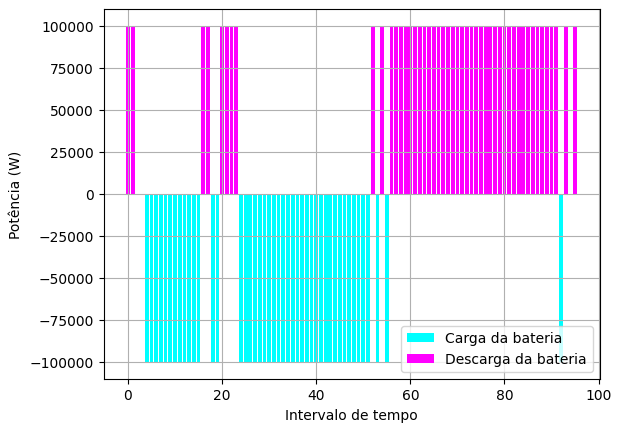

In [123]:
# Extrair valores das variáveis de decisão para listas
elec_storage_charge = [pyo.value(model.var_elec_charge[t]) for t in time]
elec_storage_discharge = [pyo.value(model.var_elec_discharge[t]) for t in time]

# Plot
plt.bar(time, [-c for c in elec_storage_charge], color='cyan', label='Carga da bateria')
plt.bar(time, elec_storage_discharge, color='magenta', label='Descarga da bateria')
plt.xlabel("Intervalo de tempo")
plt.ylabel("Potência (W)")
plt.legend()
plt.grid(True)
plt.show()

In [124]:
import pyomo.environ as pyo

# Extrair valores das variáveis Pyomo para listas
elec_storage_charge = [pyo.value(model.var_elec_charge[t]) for t in time]
elec_storage_discharge = [pyo.value(model.var_elec_discharge[t]) for t in time]

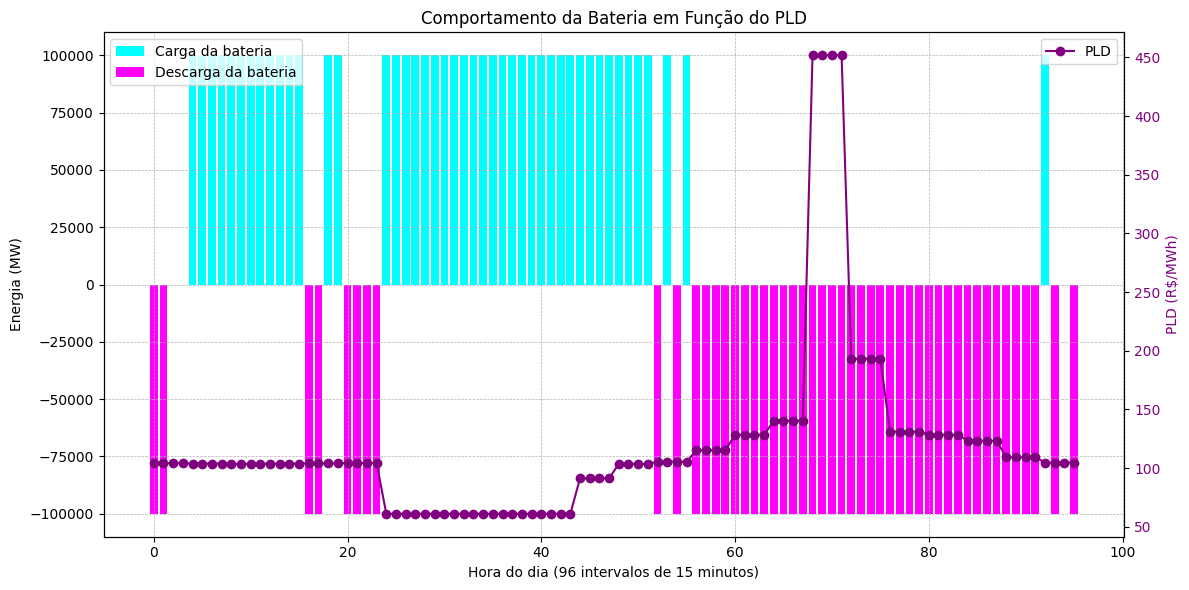

In [125]:
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Comportamento da Bateria em Função do PLD')

# Carga e descarga da bateria (barras)
ax1.bar(time, elec_storage_charge, color='cyan', label='Carga da bateria')
ax1.bar(time, [-d for d in elec_storage_discharge], color='magenta', label='Descarga da bateria')
ax1.set_xlabel('Hora do dia (96 intervalos de 15 minutos)')
ax1.set_ylabel('Energia (MW)')
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left')

# Segundo eixo y para o PLD
ax2 = ax1.twinx()
ax2.plot(time, spot_prices.Price, color='purple', marker='o', linewidth=1.5, label='PLD')
ax2.set_ylabel('PLD (R$/MWh)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [126]:
list(model.component_map(pyo.Var).keys())

['var_power_purchase',
 'var_elec_charging',
 'var_elec_discharging',
 'var_elec_charge',
 'var_elec_discharge',
 'var_elec_soc',
 'var_elet_on_off',
 'var_elec_to_h2_mass',
 'var_h2_mass_from_elet',
 'var_h2_mass_to_storage',
 'var_h2_mass_from_storage',
 'var_h2_mass_to_elec',
 'var_h2_mass_to_market',
 'var_gas_power_on_off',
 'var_gas_start_up',
 'var_gas_shut_down',
 'var_elec_from_gas',
 'var_h2_charging',
 'var_h2_discharging',
 'var_h2_charge',
 'var_h2_discharge',
 'var_h2_soc',
 'var_p2a_on_off',
 'var_p2a_power',
 'var_p2a_h2',
 'var_p2a_n2',
 'var_nh3_synth',
 'var_o2_from_p2a',
 'var_nh3_to_market',
 'var_nh3_to_chp']

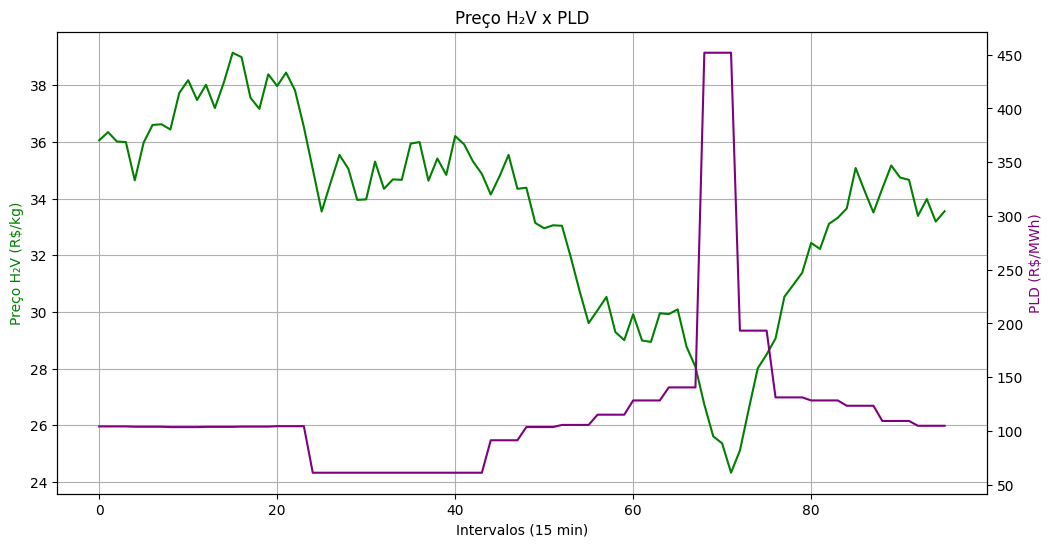

In [128]:
# 2) Preço H₂V x PLD
# =========================
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(time, h2_price, color="green", label="Preço H₂V (R$/kg)")
ax1.set_ylabel("Preço H₂V (R$/kg)", color="green")
ax1.set_xlabel("Intervalos (15 min)")
ax2 = ax1.twinx()
ax2.plot(time, spot_prices.Price, color="purple", label="PLD (R$/MWh)")
ax2.set_ylabel("PLD (R$/MWh)", color="purple")
ax1.grid(True)
ax1.set_title("Preço H₂V x PLD")
plt.show()

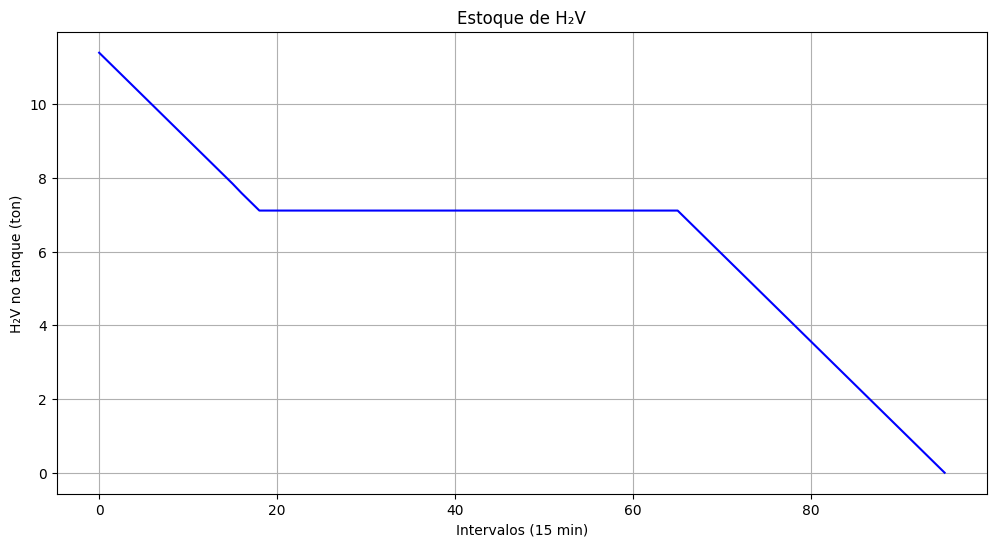

In [129]:
# 3) Estoque de H₂V
# =========================
h2_soc = [pyo.value(model.var_h2_soc[t]) for t in time]
plt.figure(figsize=(12, 6))
plt.plot(time, np.array(h2_soc)/1000, color="blue")
plt.title("Estoque de H₂V")
plt.xlabel("Intervalos (15 min)")
plt.ylabel("H₂V no tanque (ton)")
plt.grid(True)
plt.show()

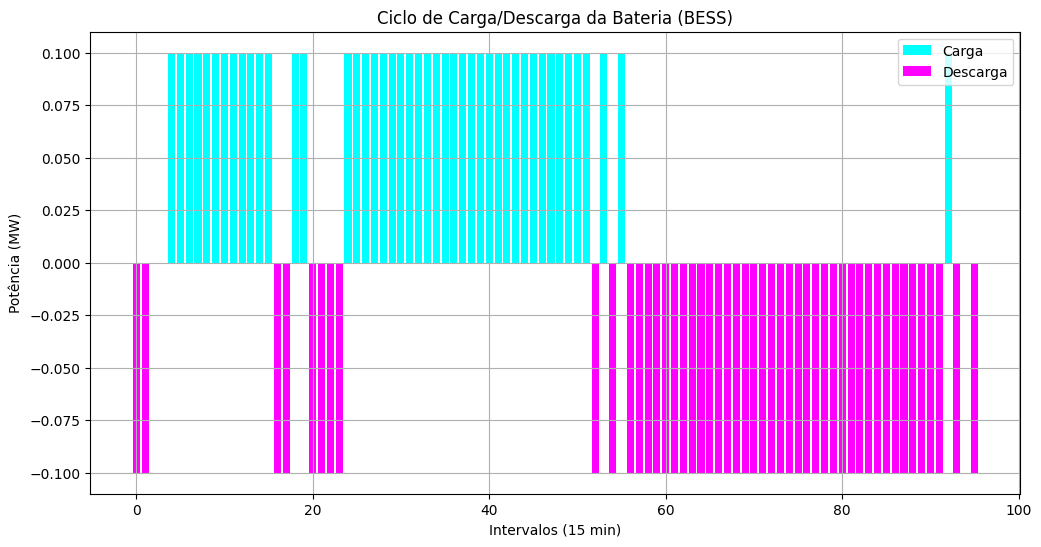

In [139]:
# 8) Ciclo de carga e descarga do BESS
# =========================
plt.figure(figsize=(12, 6))
plt.bar(time, elec_storage_charge/1e6, color="cyan", label="Carga")
plt.bar(time, -elec_storage_discharge/1e6, color="magenta", label="Descarga")
plt.title("Ciclo de Carga/Descarga da Bateria (BESS)")
plt.xlabel("Intervalos (15 min)")
plt.ylabel("Potência (MW)")
plt.grid(True)
plt.legend()
plt.show()

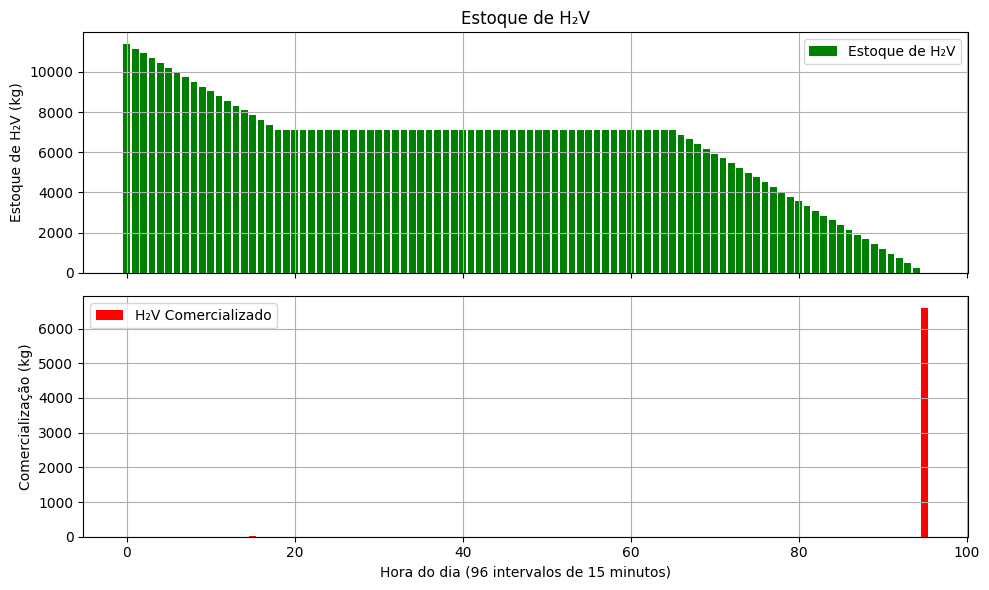

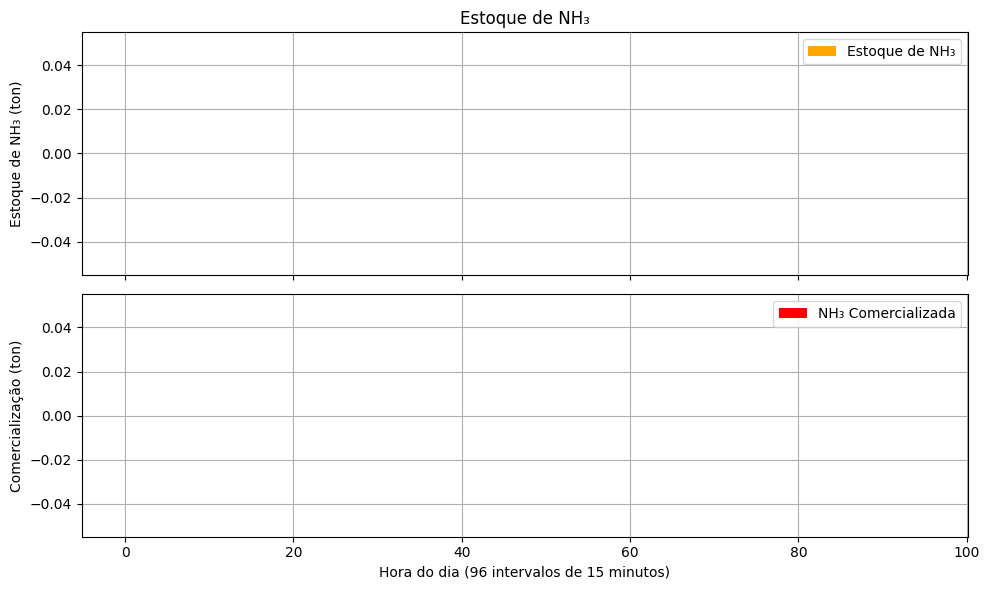

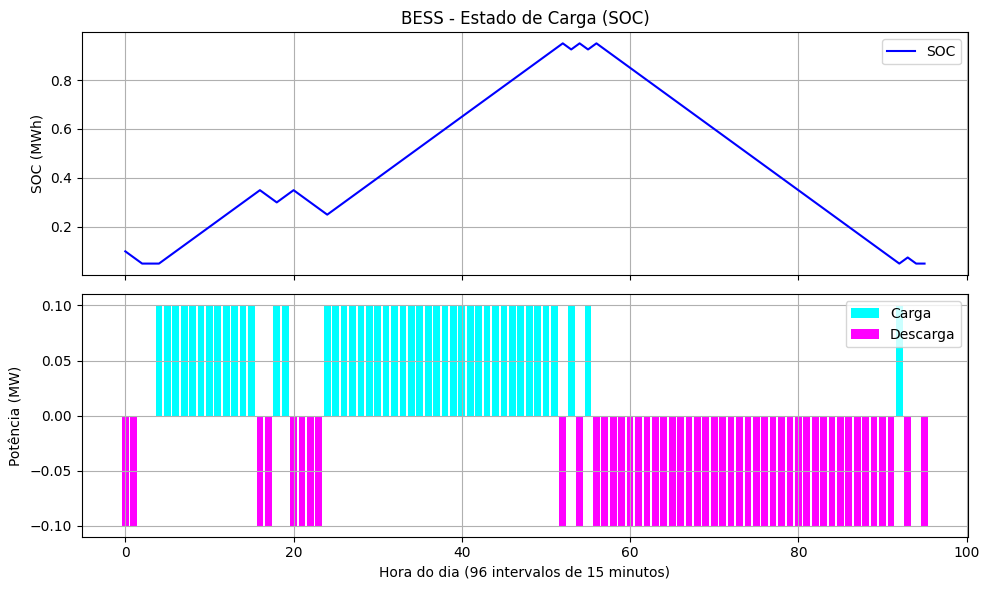

In [131]:
# =========================
# 1) H₂V - Estoque e Comercialização
# =========================
h2_soc = [pyo.value(model.var_h2_soc[t]) for t in time]
h2_market = [pyo.value(model.var_h2_mass_to_market[t]) for t in time]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Estoque
ax1.bar(time, h2_soc, color='green')
ax1.set_ylabel("Estoque de H₂V (kg)")
ax1.set_title("Estoque de H₂V")
ax1.legend(["Estoque de H₂V"])
ax1.grid(True)

# Comercialização
ax2.bar(time, h2_market, color='red')
ax2.set_ylabel("Comercialização (kg)")
ax2.set_xlabel("Hora do dia (96 intervalos de 15 minutos)")
ax2.legend(["H₂V Comercializado"])
ax2.grid(True)

plt.tight_layout()
plt.show()


# =========================
# 2) NH₃ - Estoque e Comercialização
# =========================
nh3_synth = [pyo.value(model.var_nh3_synth[t]) for t in time]
nh3_market = [pyo.value(model.var_nh3_to_market[t]) for t in time]
nh3_stock = np.cumsum(np.array(nh3_synth) - np.array(nh3_market))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Estoque
ax1.bar(time, nh3_stock, color='orange')
ax1.set_ylabel("Estoque de NH₃ (ton)")
ax1.set_title("Estoque de NH₃")
ax1.legend(["Estoque de NH₃"])
ax1.grid(True)

# Comercialização
ax2.bar(time, nh3_market, color='red')
ax2.set_ylabel("Comercialização (ton)")
ax2.set_xlabel("Hora do dia (96 intervalos de 15 minutos)")
ax2.legend(["NH₃ Comercializada"])
ax2.grid(True)

plt.tight_layout()
plt.show()


# =========================
# 3) BESS - SOC e Carga/Descarga
# =========================
elec_soc = [pyo.value(model.var_elec_soc[t]) for t in time]
elec_storage_charge = [pyo.value(model.var_elec_charge[t]) for t in time]
elec_storage_discharge = [pyo.value(model.var_elec_discharge[t]) for t in time]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# SOC
ax1.plot(time, np.array(elec_soc)/1e6, color='blue')
ax1.set_ylabel("SOC (MWh)")
ax1.set_title("BESS - Estado de Carga (SOC)")
ax1.legend(["SOC"])
ax1.grid(True)

# Carga/Descarga
ax2.bar(time, np.array(elec_storage_charge)/1e6, color='cyan', label="Carga")
ax2.bar(time, -np.array(elec_storage_discharge)/1e6, color='magenta', label="Descarga")
ax2.set_ylabel("Potência (MW)")
ax2.set_xlabel("Hora do dia (96 intervalos de 15 minutos)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


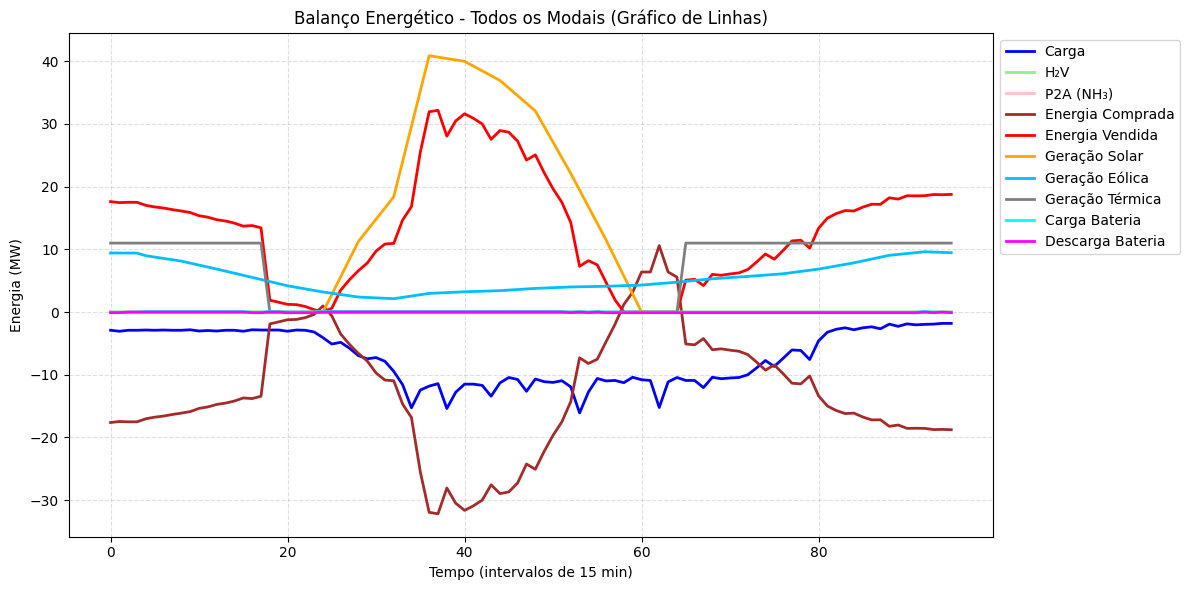

In [132]:


# --- Extrair valores ---
elec_to_h2_mass = np.array([pyo.value(model.var_elec_to_h2_mass[t]) for t in time])
power_buy = np.array([pyo.value(model.var_power_purchase[t]) for t in time])
elec_from_gas = np.array([pyo.value(model.var_elec_from_gas[t]) for t in time])
elec_storage_charge = np.array([pyo.value(model.var_elec_charge[t]) for t in time])
elec_storage_discharge = np.array([pyo.value(model.var_elec_discharge[t]) for t in time])
wind_vals = np.array([pyo.value(model.param_wind_gen[t]) for t in time])
p2a_power = np.array([pyo.value(model.var_p2a_power[t]) for t in time])
load_vals = np.array(load.pload.values)
solar_vals = np.array(pv_gen.pgen.values)

# Energia vendida
power_sell = np.array([
    max(0,
        solar_vals[i] +
        wind_vals[i] +
        elec_from_gas[i] -
        elec_to_h2_mass[i] -
        p2a_power[i] -
        load_vals[i] -
        elec_storage_charge[i] +
        elec_storage_discharge[i]
    )
    for i in range(len(time))
])

# --- Modais ---
modais = [
    ("Carga", -load_vals, "blue"),
    ("H₂V", -elec_to_h2_mass, "lightgreen"),
    ("P2A (NH₃)", -p2a_power, "pink"),
    ("Energia Comprada", power_buy, "brown"),
    ("Energia Vendida", power_sell, "red"),
    ("Geração Solar", solar_vals, "orange"),
    ("Geração Eólica", wind_vals, "deepskyblue"),
    ("Geração Térmica", elec_from_gas, "gray"),
    ("Carga Bateria", elec_storage_charge, "cyan"),
    ("Descarga Bateria", -elec_storage_discharge, "magenta")
]

# --- Gráfico em linhas ---
fig, ax = plt.subplots(figsize=(12, 6))

for nome, valores, cor in modais:
    ax.plot(time, valores / 1e6, label=nome, color=cor, linewidth=2)

ax.set_title("Balanço Energético - Todos os Modais (Gráfico de Linhas)")
ax.set_xlabel("Tempo (intervalos de 15 min)")
ax.set_ylabel("Energia (MW)")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()


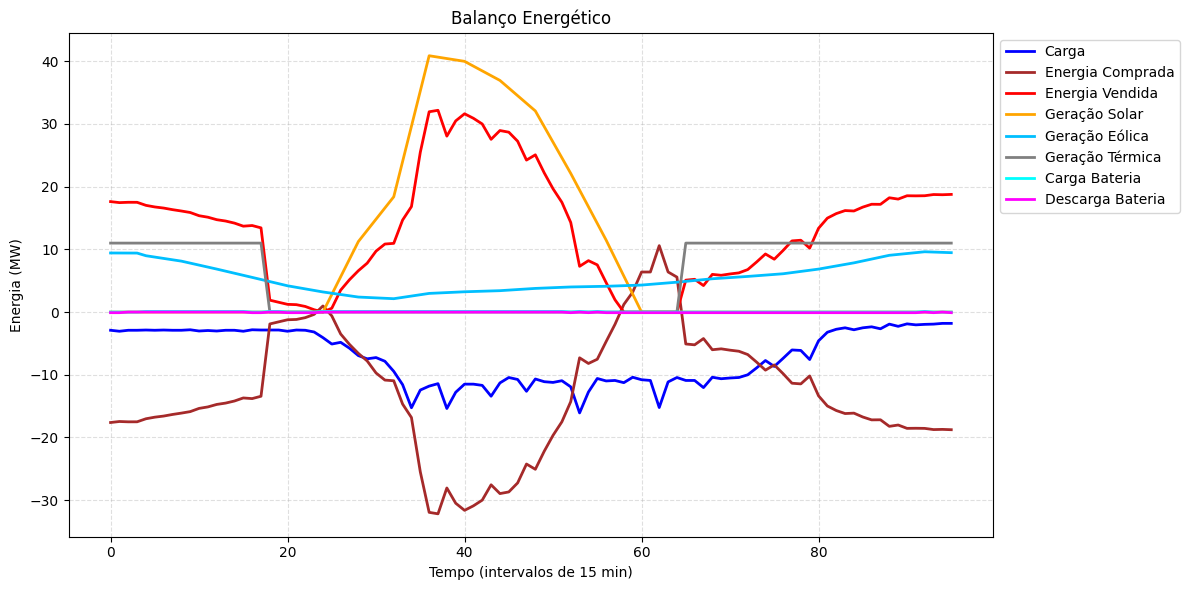

In [147]:

modais_filtrados = [
    (nome, valores, cor) for nome, valores, cor in modais
    if nome not in ["H₂V", "P2A (NH₃)"]
]

# Gráfico linhas 
fig, ax = plt.subplots(figsize=(12, 6))

for nome, valores, cor in modais_filtrados:
    ax.plot(time, valores / 1e6, label=nome, color=cor, linewidth=2)

ax.set_title("Balanço Energético")
ax.set_xlabel("Tempo (intervalos de 15 min)")
ax.set_ylabel("Energia (MW)")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()


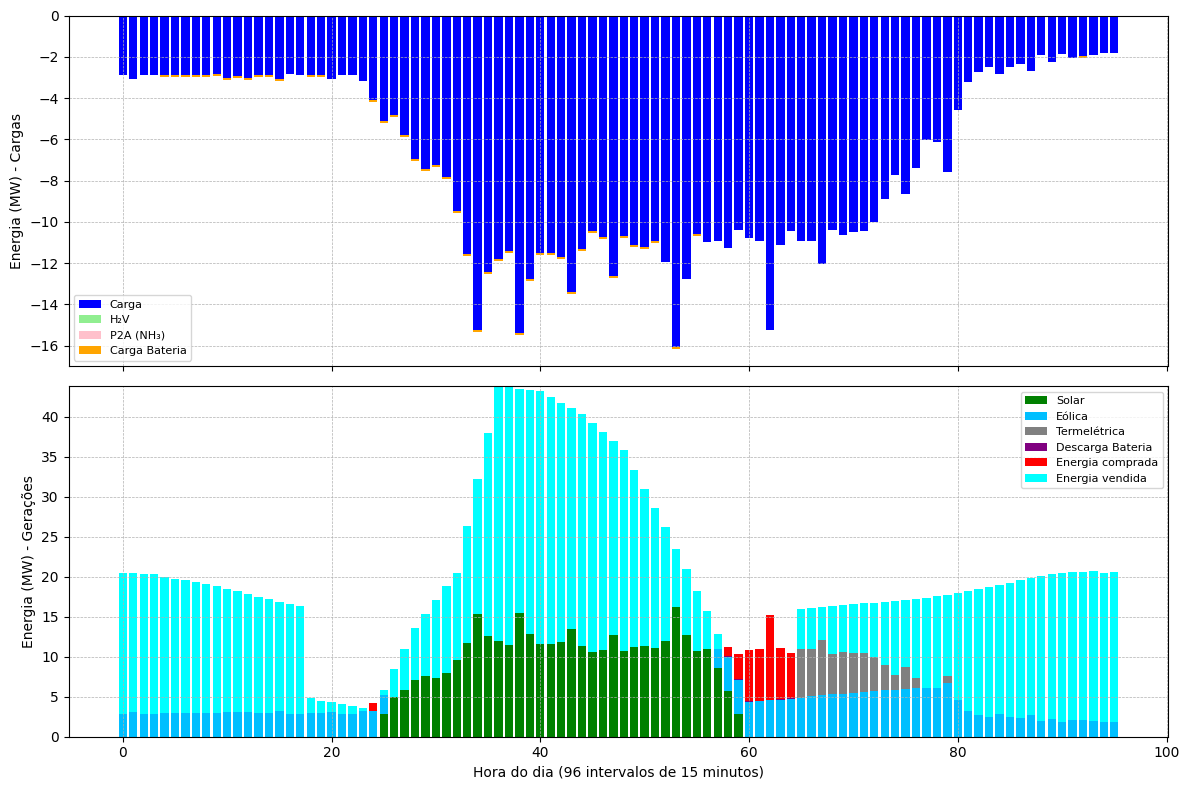

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

# --- Extração de resultados do modelo (garantindo arrays 1D em MW) ---
pv_values = pv_gen.pgen.values.astype(float) / 1e6
wind_values = np.array([pyo.value(model.param_wind_gen[t]) for t in time], dtype=float).flatten() / 1e6
elec_from_gas_values = np.array([pyo.value(model.var_elec_from_gas[t]) for t in time], dtype=float).flatten() / 1e6
elec_storage_discharge_values = np.array([pyo.value(model.var_elec_discharge[t]) for t in time], dtype=float).flatten() / 1e6
elec_storage_charge_values = np.array([pyo.value(model.var_elec_charge[t]) for t in time], dtype=float).flatten() / 1e6
power_buy_values = np.array([pyo.value(model.var_power_purchase[t]) for t in time], dtype=float).flatten() / 1e6
elec_to_h2_mass_values = np.array([pyo.value(model.var_elec_to_h2_mass[t]) for t in time], dtype=float).flatten() / 1e6
p2a_values = np.array([pyo.value(model.var_p2a_power[t]) for t in time], dtype=float).flatten() / 1e6
load_values = load.pload.values.astype(float) / 1e6

# --- Cálculo de energia vendida (em MW) ---
power_sell_values = np.array([
    max(0,
        pv_values[i] +   
        wind_values[i] +  
        elec_from_gas_values[i] -  
        elec_to_h2_mass_values[i] -  
        p2a_values[i] -  
        load_values[i] -  
        elec_storage_charge_values[i] +  
        elec_storage_discharge_values[i]
    )
    for i in range(len(time))
])

# --- Preparando negativos e bottoms ---
carga_neg = -load_values
h2v_neg = -elec_to_h2_mass_values
p2a_neg = -p2a_values
batt_charge_neg = -elec_storage_charge_values

bottom_h2v = carga_neg
bottom_p2a = bottom_h2v + h2v_neg
bottom_batt = bottom_p2a + p2a_neg

# --- Gráfico ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Painel de cargas (negativos)
ax1.bar(time, carga_neg, color='blue', label='Carga')
ax1.bar(time, h2v_neg, bottom=bottom_h2v, color='#90EE90', label='H₂V')
ax1.bar(time, p2a_neg, bottom=bottom_p2a, color='pink', label='P2A (NH₃)')
ax1.bar(time, batt_charge_neg, bottom=bottom_batt, color='orange', label='Carga Bateria')
ax1.set_ylabel('Energia (MW) - Cargas')
ax1.legend(fontsize=8)
ax1.grid(True, linestyle='--', linewidth=0.5)

# Painel de geração (positivos)
ax2.bar(time, pv_values, color='green', label='Solar')
ax2.bar(time, wind_values, bottom=pv_values, color='deepskyblue', label='Eólica')
ax2.bar(time, elec_from_gas_values, bottom=pv_values + wind_values, color='gray', label='Termelétrica')
ax2.bar(time, elec_storage_discharge_values, bottom=pv_values + wind_values + elec_from_gas_values, color='purple', label='Descarga Bateria')
ax2.bar(time, power_buy_values, bottom=pv_values + wind_values + elec_from_gas_values + elec_storage_discharge_values, color='red', label='Energia comprada')
ax2.bar(time, power_sell_values, bottom=pv_values + wind_values + elec_from_gas_values + elec_storage_discharge_values + power_buy_values, color='cyan', label='Energia vendida')
ax2.set_ylabel('Energia (MW) - Gerações')
ax2.set_xlabel('Hora do dia (96 intervalos de 15 minutos)')
ax2.legend(fontsize=8)
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


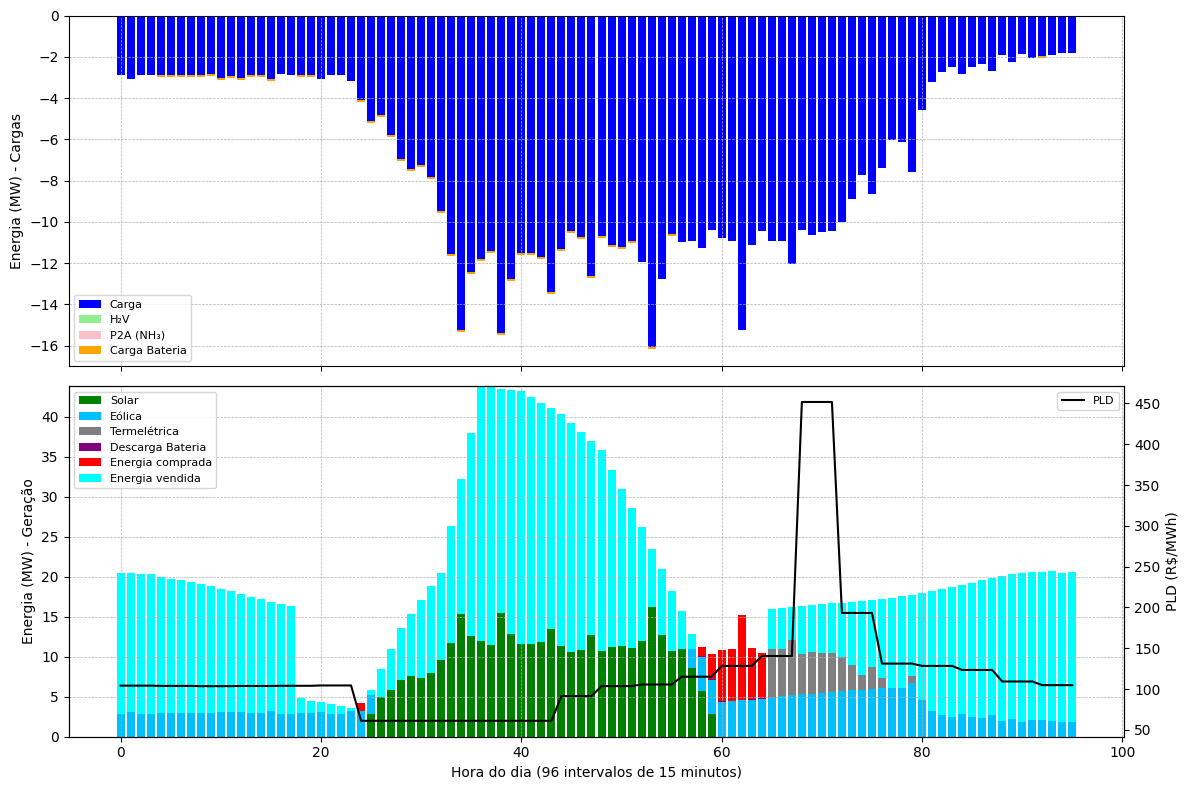

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

#  Extração
pv_values = pv_gen.pgen.values.astype(float) / 1e6
wind_values = np.array([pyo.value(model.param_wind_gen[t]) for t in time], dtype=float).flatten() / 1e6
elec_from_gas_values = np.array([pyo.value(model.var_elec_from_gas[t]) for t in time], dtype=float).flatten() / 1e6
elec_storage_discharge_values = np.array([pyo.value(model.var_elec_discharge[t]) for t in time], dtype=float).flatten() / 1e6
elec_storage_charge_values = np.array([pyo.value(model.var_elec_charge[t]) for t in time], dtype=float).flatten() / 1e6
power_buy_values = np.array([pyo.value(model.var_power_purchase[t]) for t in time], dtype=float).flatten() / 1e6
elec_to_h2_values = np.array([pyo.value(model.var_elec_to_h2_mass[t]) for t in time], dtype=float).flatten() / 1e6
p2a_values = np.array([pyo.value(model.var_p2a_power[t]) for t in time], dtype=float).flatten() / 1e6
load_values = load.pload.values.astype(float) / 1e6

# Energia vendida (MW)
power_sell_values = np.array([
    max(0,
        pv_values[i] +
        wind_values[i] +
        elec_from_gas_values[i] -
        elec_to_h2_values[i] -
        p2a_values[i] -
        load_values[i] -
        elec_storage_charge_values[i] +
        elec_storage_discharge_values[i]
    )
    for i in range(len(time))
])

#  Cargas (negativos) 
carga_neg = -load_values
h2v_neg = -elec_to_h2_values
p2a_neg = -p2a_values
batt_charge_neg = -elec_storage_charge_values

bottom_h2v = carga_neg
bottom_p2a = bottom_h2v + h2v_neg
bottom_batt = bottom_p2a + p2a_neg

#Geração (positivos) 
bottom_wind = pv_values
bottom_thermo = bottom_wind + wind_values
bottom_batt_discharge = bottom_thermo + elec_from_gas_values
bottom_buy = bottom_batt_discharge + elec_storage_discharge_values
bottom_sell = bottom_buy + power_buy_values


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

#  Cargas 
ax1.bar(time, carga_neg, color='blue', label='Carga')
ax1.bar(time, h2v_neg, bottom=bottom_h2v, color='#90EE90', label='H₂V')
ax1.bar(time, p2a_neg, bottom=bottom_p2a, color='pink', label='P2A (NH₃)')
ax1.bar(time, batt_charge_neg, bottom=bottom_batt, color='orange', label='Carga Bateria')
ax1.set_ylabel('Energia (MW) - Cargas')
ax1.legend(fontsize=8)
ax1.grid(True, linestyle='--', linewidth=0.5)

#  Geração
ax2.bar(time, pv_values, color='green', label='Solar')
ax2.bar(time, wind_values, bottom=bottom_wind, color='deepskyblue', label='Eólica')
ax2.bar(time, elec_from_gas_values, bottom=bottom_thermo, color='gray', label='Termelétrica')
ax2.bar(time, elec_storage_discharge_values, bottom=bottom_batt_discharge, color='purple', label='Descarga Bateria')
ax2.bar(time, power_buy_values, bottom=bottom_buy, color='red', label='Energia comprada')
ax2.bar(time, power_sell_values, bottom=bottom_sell, color='cyan', label='Energia vendida')

# Linha do PLD
ax2b = ax2.twinx()
ax2b.plot(time, spot_prices.Price, color='black', linewidth=1.5, label='PLD')
ax2b.set_ylabel('PLD (R$/MWh)', color='black')
ax2b.tick_params(axis='y', labelcolor='black')

# Legendas e layout
ax2.set_ylabel('Energia (MW) - Geração')
ax2.set_xlabel('Hora do dia (96 intervalos de 15 minutos)')
ax2.legend(fontsize=8, loc='upper left')
ax2b.legend(fontsize=8, loc='upper right')
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


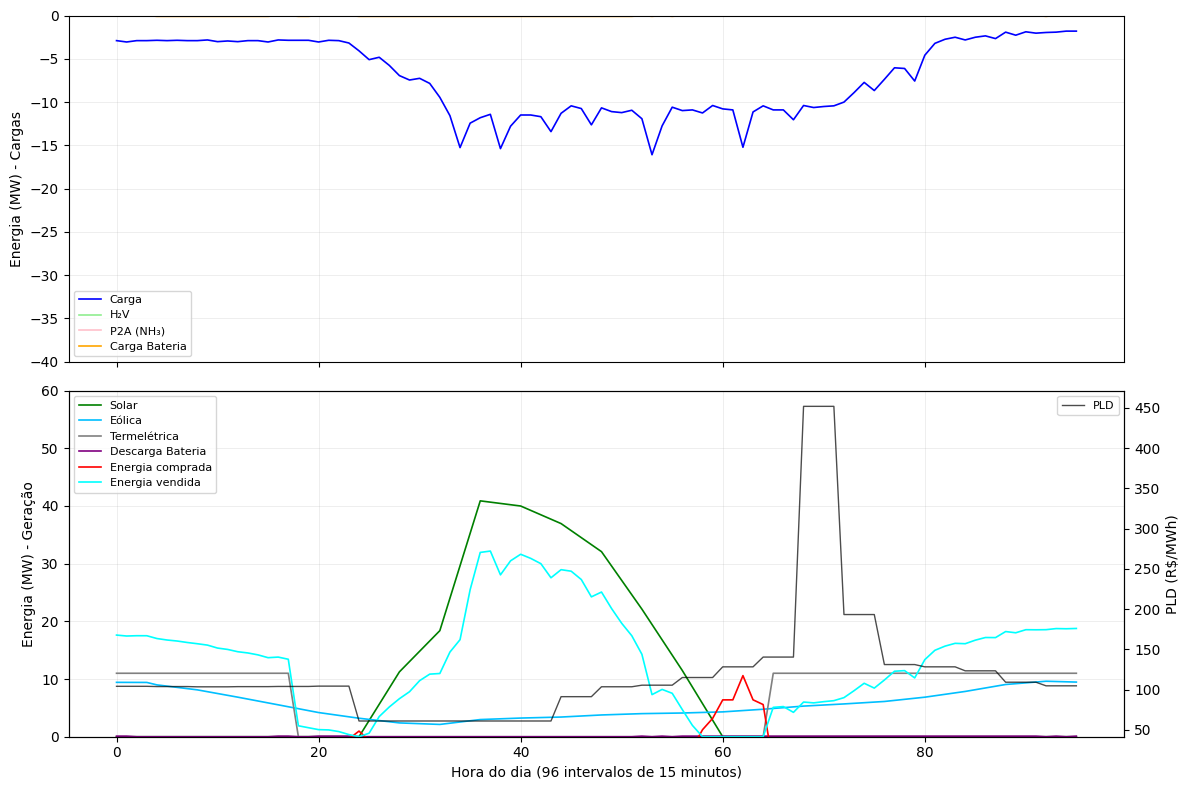

In [140]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, facecolor='none')

# --- Painel de Cargas (linhas) ---
ax1.plot(time, carga_neg, color='blue', linestyle='-', linewidth=1.2, label='Carga')
ax1.plot(time, h2v_neg, color='#90EE90', linestyle='-', linewidth=1.2, label='H₂V')
ax1.plot(time, p2a_neg, color='pink', linestyle='-', linewidth=1.2, label='P2A (NH₃)')
ax1.plot(time, batt_charge_neg, color='orange', linestyle='-', linewidth=1.2, label='Carga Bateria')

ax1.set_ylabel('Energia (MW) - Cargas')
ax1.set_ylim(-40, 0)
ax1.legend(fontsize=8)
ax1.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)

# --- Painel de Geração (linhas) ---
ax2.plot(time, pv_values, color='green', linestyle='-', linewidth=1.2, label='Solar')
ax2.plot(time, wind_values, color='deepskyblue', linestyle='-', linewidth=1.2, label='Eólica')
ax2.plot(time, elec_from_gas_values, color='gray', linestyle='-', linewidth=1.2, label='Termelétrica')
ax2.plot(time, elec_storage_discharge_values, color='purple', linestyle='-', linewidth=1.2, label='Descarga Bateria')
ax2.plot(time, power_buy_values, color='red', linestyle='-', linewidth=1.2, label='Energia comprada')
ax2.plot(time, power_sell_values, color='cyan', linestyle='-', linewidth=1.2, label='Energia vendida')

ax2.set_ylim(0, 60)

ax2b = ax2.twinx()
ax2b.plot(time, spot_prices.Price, color='black', linewidth=1, alpha=0.7, label='PLD')
ax2b.set_ylabel('PLD (R$/MWh)', color='black')
ax2b.tick_params(axis='y', labelcolor='black')

ax2.set_ylabel('Energia (MW) - Geração')
ax2.set_xlabel('Hora do dia (96 intervalos de 15 minutos)')
ax2.legend(fontsize=8, loc='upper left')
ax2b.legend(fontsize=8, loc='upper right')
ax2.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

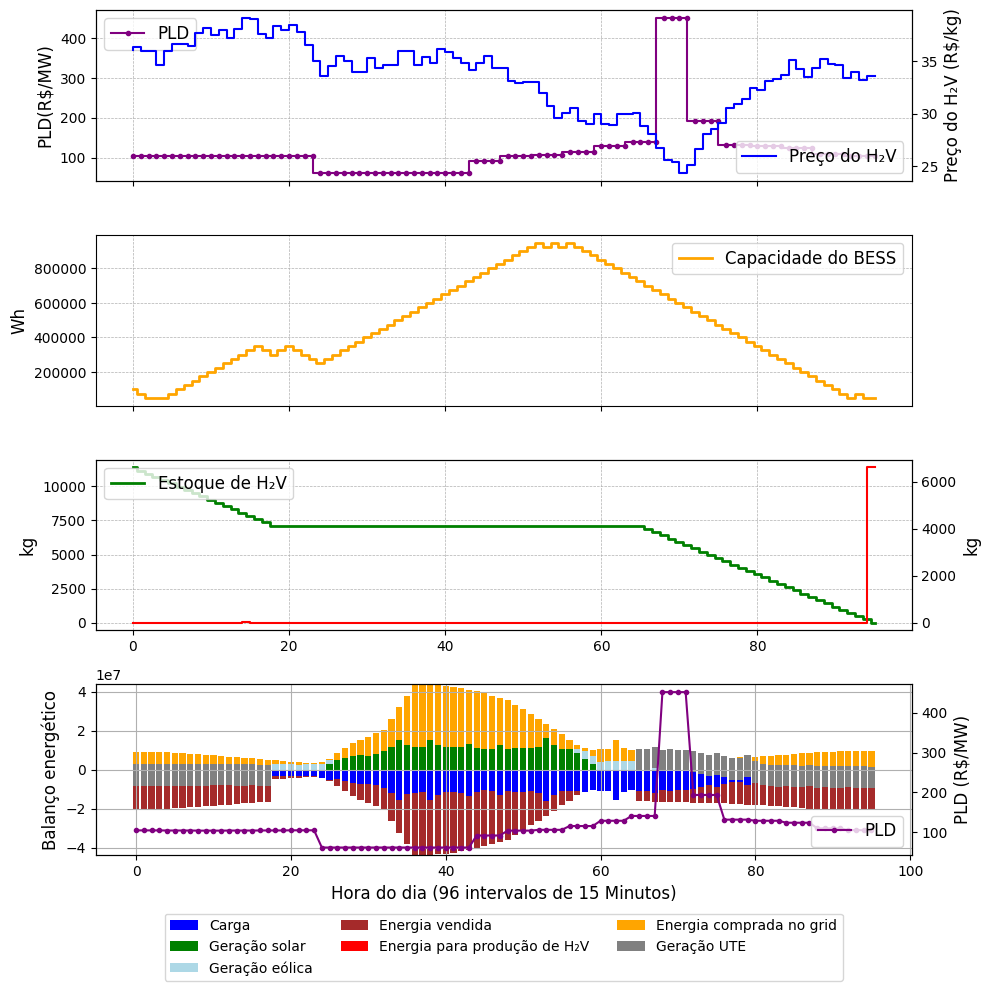

In [146]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Extração das variáveis necessárias para os gráficos
soc_elec = np.array([pyo.value(model.var_elec_soc[t]) for t in time])
soc_h2 = np.array([pyo.value(model.var_h2_soc[t]) for t in time])
h2_to_market = np.array([pyo.value(model.var_h2_mass_to_market[t]) for t in time])


# Definindo o fundo como branco (removendo transparência)
plt.gcf().set_facecolor('white')

# Função para formatar o eixo y em milhões
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)  # Converte para milhões e formata com 1 casa decimal

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10), facecolor='white')


# Gráfico 1: Preço do hidrogênio e PLD
ax1.step(time, spot_prices, color='purple', label='PLD', marker='.')#where='mid', linestyle='dotted', linewidth=2)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Formatar o eixo x como HH:MM
ax1.set_xticklabels([])  # Remove os rótulos do eixo x para evitar sobreposição
ax1.set_ylabel('PLD(R$/MW)', fontsize=12)

# Criando um segundo eixo y para o preço do hidrogênio
ax1_2 = ax1.twinx()
ax1_2.step(time, h2_price, color='blue', label='Preço do H₂V')#, where='mid', linestyle='solid', linewidth=2)
ax1_2.set_ylabel('Preço do H₂V (R$/kg)', fontsize=12)

# Ajustar as legendas dos dois eixos y
ax1.legend(loc='upper left', fontsize=12)
ax1_2.legend(loc='lower right', fontsize=12)


# Gráfico 2: Nível de carga da bateria
ax2.step(time, soc_elec, color='orange', label='Capacidade do BESS', where='mid', linestyle='-', linewidth=2)
ax2.set_ylabel('Wh', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.set_xticklabels([])  # Remove os rótulos do eixo x para evitar sobreposição

# Gráfico 3: Nível do tanque de hidrogênio e h2_to_market
ax3.step(time, soc_h2, color='green', label='Estoque de H₂V', where='mid', linestyle='-', linewidth=2)
ax3.set_ylabel('kg', fontsize=12)
ax3.legend(loc='upper left', fontsize=12)
ax3.grid(True, linestyle='--', linewidth=0.5)

# Criando um segundo eixo y para h2_to_market
ax3b = ax3.twinx()
ax3b.step(time, h2_to_market, color='red', label='H₂V comercializado')#, where='mid', linestyle='dotted', linewidth=2)
ax3b.set_ylabel('kg', fontsize=12)
#x3b.legend(loc='upper right', fontsize=12)

# Gráfico 4: Comercialização de Energia e Geração Termelétrica
ax4.bar(time, -load.pload.values, label='Carga', color='blue')  # OK
ax4.bar(time, pv_gen.pgen.values, label='Geração solar', color='green')
ax4.bar(time, wind_gen.pwind.values, bottom=pv_gen.pgen.values, label='Geração eólica', color='lightblue')
ax4.bar(time, -power_sell, bottom=-load.pload.values-elec_to_h2_mass, label='Energia vendida', color='brown')
ax4.bar(time, -elec_to_h2_mass, bottom=-load.pload.values-power_sell, label='Energia para produção de H₂V', color='red')
#ax4.bar(time, power_buy, bottom=pv_gen.pgen.values, label='Energia comprada no grid', color='orange')
ax4.bar(time, power_buy, bottom=pv_gen.pgen.values + wind_gen.pwind.values, label='Energia comprada no grid', color='orange')
#ax4.bar(time, power_plant, label='Geração UTE', color='gray')
ax4.bar(time, elec_from_gas, bottom=pv_gen.pgen.values + wind_gen.pwind.values + power_buy, label='Geração UTE', color='gray')


ax4.set_xlabel('Hora do dia (96 intervalos de 15 Minutos)', fontsize=12)
ax4.set_ylabel('Balanço energético', fontsize=12)
ax4.grid(True)

# Criando um segundo eixo y para o PLD (Preço Spot)
ax5 = ax4.twinx()
ax5.plot(time, spot_prices.Price, color='purple', label='PLD', marker='.')
ax5.set_ylabel('PLD (R$/MW)', fontsize=12)

# Legendas separadas
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)  # Ajuste ncol conforme necessário
ax5.legend(loc='lower right', fontsize=12)

# Melhorar o layout e ajustar os espaçamentos
fig.tight_layout()

# Salvando o gráfico no formato EPS, sem transparência e com o texto como curvas
#plt.savefig('Cen_1_multi_graph.eps', format='eps', transparent=False)

# Mostra o gráfico na tela
plt.show()


In [ ]:
# Define o período em horas (exemplo de uma hora)
periodo_horas = 1

# Calcula o total de potência comprada e vendida em MWh
total_power_buy_mwh = np.sum(power_buy) / 1000000 * periodo_horas
total_power_sell_mwh = np.sum(power_sell) / 1000000 * periodo_horas
total_elec_from_gas_mwh = np.sum(elec_from_gas) / 1000000 * periodo_horas
total_elec_to_h2_mwh = np.sum(elec_to_h2_mass) / 1000000 * periodo_horas

print("Total de Potência Comprada (MWh):", total_power_buy_mwh)
print("Total de Potência Vendida (MWh):", total_power_sell_mwh)
print("Total de Potência Gerada na UTE (MWh):", total_elec_from_gas_mwh)
print("Massa total de H2 produzida (kg):", total_elec_to_h2_mwh)


In [138]:
model.solver

AttributeError: 'ConcreteModel' object has no attribute 'solver'